In [4]:
# Function to load CIFAR-10 files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
        data = dict['data'].reshape((len(dict['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        labels = dict['labels']
    return data, labels


In [5]:
import numpy as np

# Loading data and splitting data into training and validation data
fname = 'cifar-10-python/cifar-10-batches-py/data_batch_'
for i in range(1,6):
    if i == 1:
        data, labels = unpickle(fname+str(i))
    else:
        dt, lb = unpickle(fname+str(i))
        data = np.append(data,dt, axis=0)
        labels = labels + lb
print(data.shape)

train_data = data[0:30000, :, :, :]
train_labels = labels[0:30000]
print('Data Shape and Label Length of training data: ' + str(train_data.shape) + " - " + str(len(train_labels)))

validation_data = data[30000:50000, :, :, :]
validation_labels = labels[30000:50000]
print('Data Shape and Label Length of validation data: ' + str(validation_data.shape) + " - " + str(len(validation_labels)))

# Loading test data
fname = 'cifar-10-python/cifar-10-batches-py/test_batch'
test_data, test_labels = unpickle(fname)
print('Data Shape and Label Length of test data: ' + str(test_data.shape) + " - " + str(len(test_labels)))

# Scaling into [0,1] interval
train_data = train_data.astype('float32')/255
validation_data = validation_data.astype('float32')/255
test_data = test_data.astype('float32')/255

# Make labels categorical
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)


(50000, 32, 32, 3)
Data Shape and Label Length of training data: (30000, 32, 32, 3) - 30000
Data Shape and Label Length of validation data: (20000, 32, 32, 3) - 20000
Data Shape and Label Length of test data: (10000, 32, 32, 3) - 10000


In [10]:
# Define a basic convolutional network with 3 layers
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Define the densely conneted clasifier
model.add(layers.Flatten())

# Add Drop out
model.add(layers.Dropout(0.3))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
__________

In [11]:
from keras import optimizers

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

test_datagen.fit(train_data)

train_generator = train_datagen.flow(
        train_data,
        train_labels,
        batch_size=32
        )

validation_generator = test_datagen.flow(
        validation_data,
        validation_labels,
        batch_size=32,
        )

In [16]:
# Fit the model
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=len(train_data) / 32, # 32 is the batch size
                    epochs=1, # Must be 100 on Terra
                    validation_data=validation_generator,
                    validation_steps=len(validation_data) / 32 # 32 is the batch size
                   )


Epoch 1/1
938/937 [==============================] - 184s 196ms/step - loss: 0.9255 - acc: 0.6816 - val_loss: 0.8908 - val_acc: 0.7045


In [18]:
model.save('cifar-10-augmentation.h5')

In [19]:
# run this cell if only if model was trained on terra
from keras.models import load_model
import pickle

model = load_model('terra/' + 'cifar-10-augmentation.h5')

with open('terra/' + 'cifar-10-augmentation-history.pickle', 'rb') as f:
    data = pickle.load(f)

history.history = data

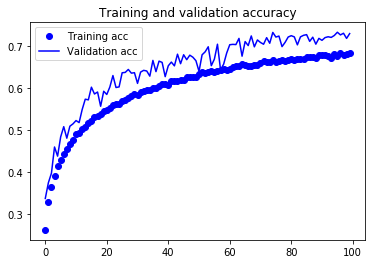

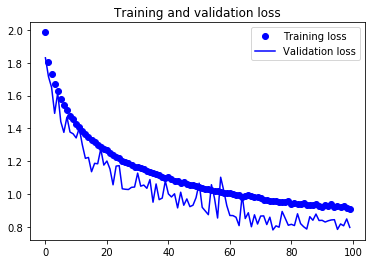

In [21]:
# Plot the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
test_loss, test_acc = model.evaluate(test_data, test_labels)
print('test_acc: ', test_acc)

10000/10000 [==============================] - 17s 2ms/step
test_acc:  0.74
